In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline


In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 50 kB 1.5 MB/s 


In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".PNG" or ftype ==".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../input/idontknow/train/benign',224))
malign_train = np.array(Dataset_loader('../input/idontknow/train/malignant',224))
benign_test = np.array(Dataset_loader('../input/idontknow/test/benign',224))
malign_test = np.array(Dataset_loader('../input/idontknow/test/malignant',224))

100%|██████████| 258/258 [00:02<00:00, 118.73it/s]


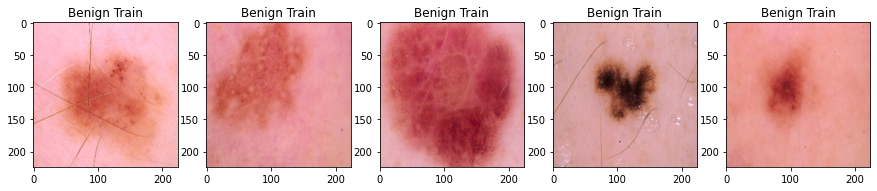

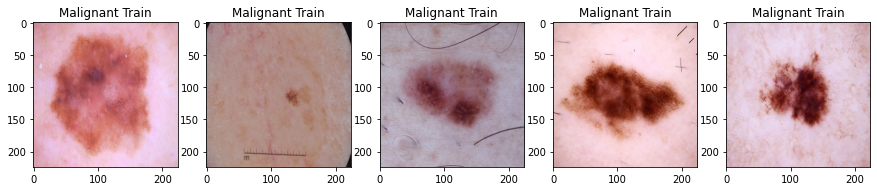

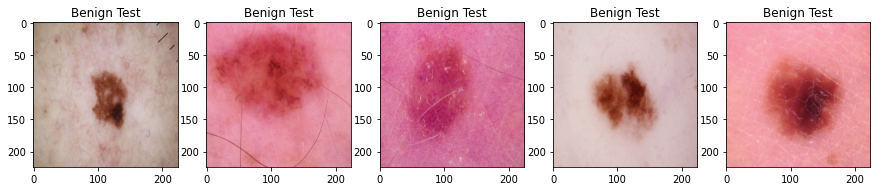

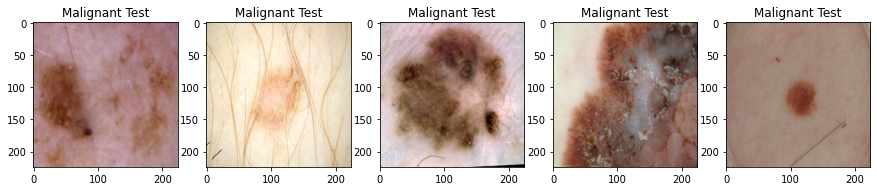

In [5]:

def plot_any(arr, title = ''):
    """
    plot multiple pictures
    """
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);
        
plot_any(benign_train[:5], title = "Benign Train")
plot_any(malign_train[:5], title = "Malignant Train")
plot_any(benign_test[:5], title = "Benign Test")
plot_any(malign_test[:5], title = "Malignant Test")


In [6]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=SEED
)

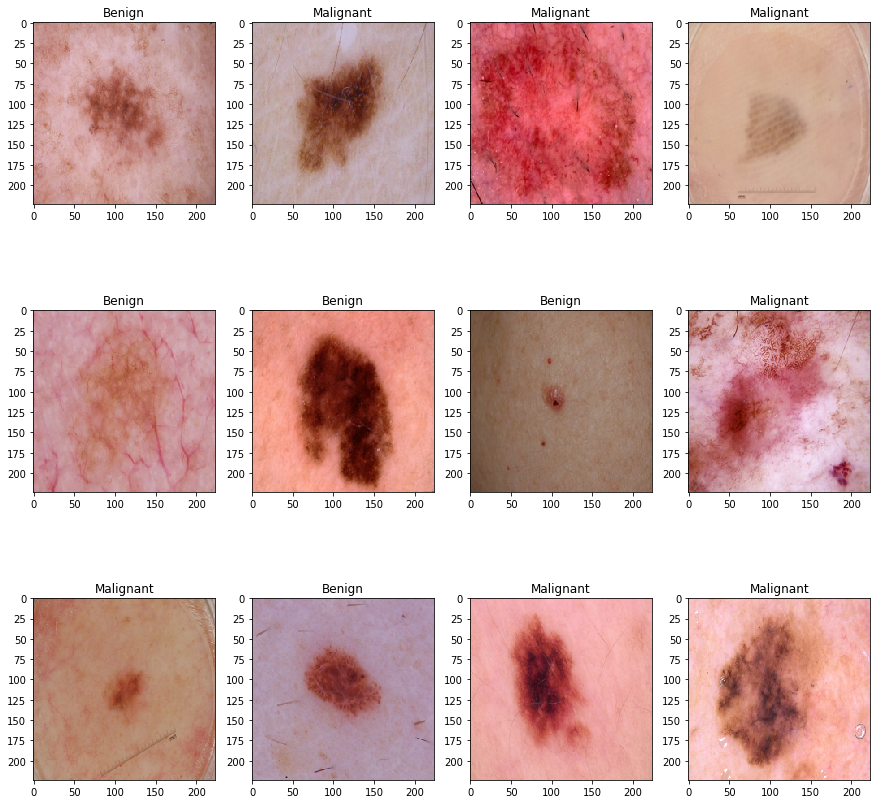

In [8]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input

BATCH_SIZE = 32

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25),
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

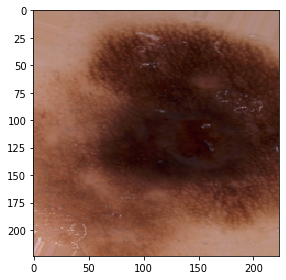

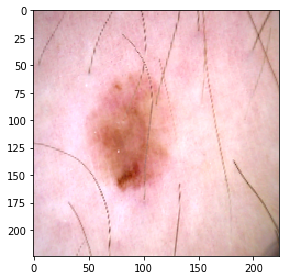

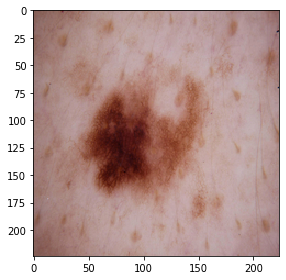

In [10]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
x3, y3 = test_generator[0]

imshow(x1[5])
imshow(x2[0])
imshow(x3[0])

In [11]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    return model


In [12]:
'''base_model = efn.EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False
                   )'''

#lets try mobilenet
from keras.preprocessing.image import ImageDataGenerator

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")

model = build_model(base_model)
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,265,666
Trainable params: 2,228,994
Non-trainable params: 36,672
_________________________________________________________________


In [13]:
from keras import models, layers
from keras.optimizers import Adam

# Learning Rate Reducer
learning_rate = 5e-5
epochs = 10

# Checkpoint
filepath="mobile_weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [14]:


history = model.fit(train_generator, 
                              epochs=30, 
                              shuffle=True, 
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                              validation_steps = x_val.shape[0] // BATCH_SIZE,
                              validation_data=val_generator,
                              callbacks=[checkpoint]
                              )



Epoch 1/30
98/98 [==============================] - 59s 483ms/step - loss: 0.7435 - acc: 0.6568 - val_loss: 2.9863 - val_acc: 0.4362

Epoch 00001: val_acc improved from -inf to 0.43620, saving model to mobile_weights.best.hdf5
Epoch 2/30
98/98 [==============================] - 46s 465ms/step - loss: 0.6053 - acc: 0.7445 - val_loss: 2.4222 - val_acc: 0.4453

Epoch 00002: val_acc improved from 0.43620 to 0.44531, saving model to mobile_weights.best.hdf5
Epoch 3/30
98/98 [==============================] - 46s 466ms/step - loss: 0.4971 - acc: 0.7921 - val_loss: 3.3982 - val_acc: 0.4427

Epoch 00003: val_acc did not improve from 0.44531
Epoch 4/30
98/98 [==============================] - 45s 458ms/step - loss: 0.5177 - acc: 0.7898 - val_loss: 3.4585 - val_acc: 0.4440

Epoch 00004: val_acc did not improve from 0.44531
Epoch 5/30
98/98 [==============================] - 45s 463ms/step - loss: 0.4601 - acc: 0.8099 - val_loss: 2.4468 - val_acc: 0.4661

Epoch 00005: val_acc improved from 0.4453

In [15]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

model.save("model_mobileV2.h5")
print("Saved model")    

Saved model


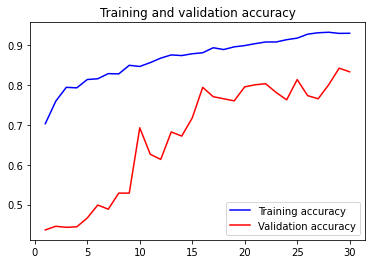

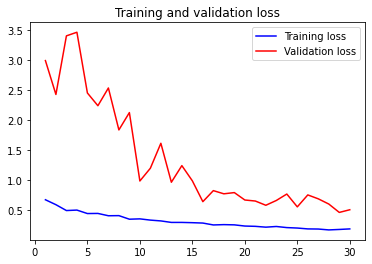

In [16]:
'''history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()'''



acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

In [17]:
model.load_weights("mobile_weights.best.hdf5")

#dados de validação

val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))


0.8662420382165605

In [18]:
#dados teste

test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8946360153256705

Normalized confusion matrix
[[0.84469697 0.15530303]
 [0.05426357 0.94573643]]


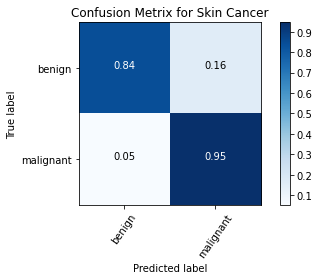

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

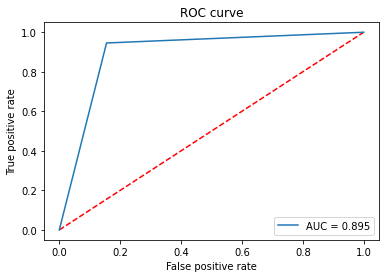

In [20]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [21]:
#Classification report

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       264
           1       0.86      0.95      0.90       258

    accuracy                           0.89       522
   macro avg       0.90      0.90      0.89       522
weighted avg       0.90      0.89      0.89       522

